# Referances
* https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

* https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566

* https://stackoverflow.com/questions/62471102/unable-to-save-model-architecture-bilstm-attention

* https://www.py4u.net/discuss/261153

In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import reuters
import nltk
from sklearn.model_selection import train_test_split
import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
# nltk.download('reuters')
# !unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

In [ ]:
train_documents, train_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('training/')])
test_documents, test_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('test/')])

In [ ]:
print("Number of training documents:", len(train_documents))
print("Number of testing documents:", len(test_documents))

Number of training documents: 7769
Number of testing documents: 3019


In [ ]:
train_categories = [i[0] for i in train_categories]
test_categories = [i[0] for i in test_categories]

In [ ]:
trainData = {"content": train_documents}
testData = {"content": test_documents}
trainDf = pd.DataFrame(trainData, columns=["content"])
trainDf['label'] = train_categories
testDf = pd.DataFrame(testData, columns=["content"])
testDf['label'] = test_categories

In [ ]:
trainDf.label.value_counts()[0:10]

earn            2843
acq             1650
crude            370
interest         329
money-fx         266
trade            253
grain            218
corn             157
dlr              126
money-supply     125
Name: label, dtype: int64

In [ ]:
trainDf = trainDf[trainDf.label.isin(['crude','interest','money-fx','trade','grain','money-supply'])]
testDf = testDf[testDf.label.isin(['crude','interest','money-fx','trade','grain','money-supply'])]

In [ ]:
trainDf.shape, testDf.shape

((1561, 2), (584, 2))

# Bidirectional LSTM

In [ ]:
# !pip install keras_self_attention

In [ ]:
def compute_model_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    labels = np.argmax(labels, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average = 'weighted')
    precision = precision_score(y_true=labels, y_pred=pred , average= 'weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.wrappers import Bidirectional
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.constraints import maxnorm
from keras.models import model_from_json
# from keras.optimizers import Adam
from keras import regularizers
from keras.utils.vis_utils import plot_model
# from keras_self_attention import SeqSelfAttention
from keras.models import Sequential
import keras
import tensorflow as tf


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256
# This is fixed.
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(trainDf['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15930 unique tokens.


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
import numpy as np

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-06-28 12:18:43--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.200.96
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.200.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  30.4MB/s    in 51s     

2021-06-28 12:19:35 (30.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
print('> loading word2vec embeddings')
#B. Word2Vecvec Using Gensim
word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)


> loading word2vec embeddings


In [ ]:
# Creating embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
del (word_vectors)
print('MATRIX ELEMENTS', embedding_matrix[0:10])

MATRIX ELEMENTS [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.08007812  0.10498047  0.04980469 ...  0.00366211  0.04760742
  -0.06884766]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.01177979 -0.04736328  0.04467773 ...  0.07128906 -0.03491211
   0.02416992]]


In [ ]:
from keras.layers import Layer, InputSpec
from keras import backend as K
from keras import initializers
from keras import regularizers
from keras import constraints


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):


        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'W_regularizer': self.W_regularizer,
                'u_regularizer': self.u_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'u_constraint': self.u_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)


    def call(self, x):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.softmax(ait)
        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)


    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


In [ ]:
X = tokenizer.texts_to_sequences(trainDf['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train data tensor:', X.shape)

Shape of train data tensor: (1561, 256)


In [ ]:
X_test = tokenizer.texts_to_sequences(testDf['content'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', X_test.shape)

Shape of test data tensor: (584, 256)


In [ ]:
Y = pd.get_dummies(trainDf['label']).values
print('Shape of train label tensor:', Y.shape)

Shape of train label tensor: (1561, 6)


In [ ]:
Y_test = pd.get_dummies(testDf['label']).values
print('Shape of test label tensor:', Y_test.shape)

Shape of test label tensor: (584, 6)


In [ ]:
# X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.10, random_state = 42)
# print(X_train.shape,Y_train.shape)
# print(X_val.shape,Y_val.shape)

In [ ]:
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,),dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
#                             embeddings_regularizer=regularizers.l2(0.00),
                            trainable=False)(input_layer)
drop1 = SpatialDropout1D(0.2)(embedding_layer)
lstm_1 = Bidirectional(LSTM(64, name='blstm_1', activation='tanh',return_sequences=True,dropout=0.1), merge_mode='concat')(drop1)
lstm_2 = Bidirectional(LSTM(32, name='blstm_2', activation='tanh',return_sequences=True,dropout=0.1), merge_mode='concat')(lstm_1)
# lstm_1 = BatchNormalization()(lstm_1)
drop2 = Dropout(0.4)(lstm_2)
concat = concatenate([lstm_2,drop2, lstm_1], name='Concatenate')
att_layer = AttentionWithContext()(concat)
drop3 = Dropout(0.5)(att_layer)
predictions = Dense(6, activation='softmax')(drop3)

model = Model(inputs=input_layer, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 300)     4779300     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 256, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256, 128)     186880      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

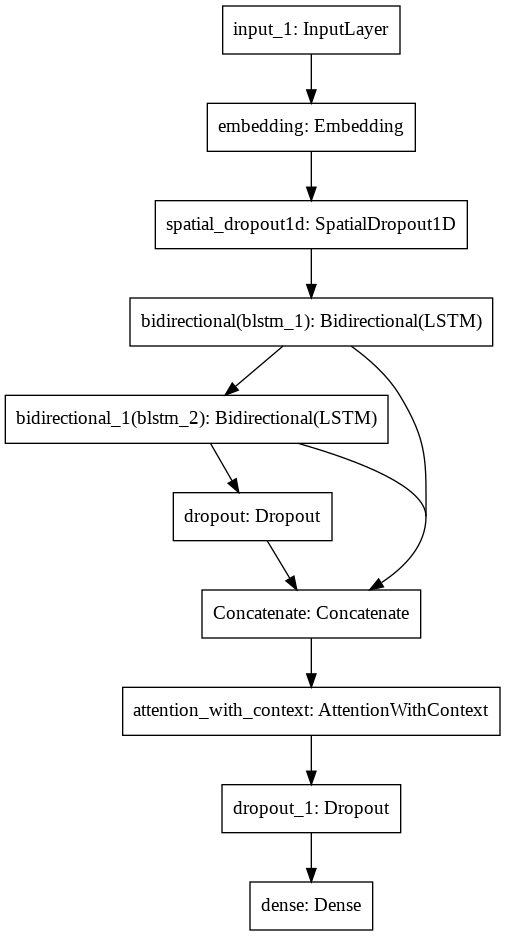

In [ ]:
plot_model(model)

In [ ]:
# keras.backend.clear_session()
# sess = tf.compat.v1.Session()
# sess.as_default()
monitor_metric = 'val_categorical_accuracy'
STAMP = 'news_BiLSTM_Skip_Atten_w2v256'
early_stopping =EarlyStopping(monitor=monitor_metric,
    patience=5)
bst_model_path = STAMP + '.hdf5'
model_checkpoint = ModelCheckpoint(bst_model_path,
    monitor=monitor_metric,
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False)

hist = model.fit(X, Y,
    validation_data=(X_test, Y_test),
    epochs=100,
    batch_size=32,
    shuffle=False,  
    callbacks=[model_checkpoint,early_stopping])

Epoch 1/100
49/49 [==============================] - 59s 642ms/step - loss: 1.6727 - categorical_accuracy: 0.3011 - val_loss: 0.7454 - val_categorical_accuracy: 0.7432

Epoch 00001: val_categorical_accuracy improved from -inf to 0.74315, saving model to news_BiLSTM_Skip_Atten_w2v256.hdf5
Epoch 2/100
49/49 [==============================] - 30s 607ms/step - loss: 0.7906 - categorical_accuracy: 0.6989 - val_loss: 0.4494 - val_categorical_accuracy: 0.8493

Epoch 00002: val_categorical_accuracy improved from 0.74315 to 0.84932, saving model to news_BiLSTM_Skip_Atten_w2v256.hdf5
Epoch 3/100
49/49 [==============================] - 30s 612ms/step - loss: 0.5279 - categorical_accuracy: 0.8140 - val_loss: 0.3762 - val_categorical_accuracy: 0.8682

Epoch 00003: val_categorical_accuracy improved from 0.84932 to 0.86815, saving model to news_BiLSTM_Skip_Atten_w2v256.hdf5
Epoch 4/100
49/49 [==============================] - 30s 607ms/step - loss: 0.4373 - categorical_accuracy: 0.8369 - val_loss: 0

In [ ]:
def create_custom_objects():
    instance_holder = {"instance": None}

    class ClassWrapper(AttentionWithContext):
        def __init__(self, *args, **kwargs):
            instance_holder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instance_holder["instance"], "loss_function")
        return method(*args)

    def accuracy(*args):
        method = getattr(instance_holder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"AttentionWithContext": ClassWrapper, "loss": loss,
            "accuracy":accuracy}

In [ ]:
from keras.models import load_model
best_model = load_model('news_BiLSTM_Skip_Atten_w2v256.hdf5',custom_objects=create_custom_objects())



In [ ]:
best_model.evaluate(X_test, Y_test) # or model.predict

19/19 [==============================] - 4s 134ms/step - loss: 0.3863 - categorical_accuracy: 0.8853


[0.3863168954849243, 0.8852739930152893]

In [ ]:
y_pred  = best_model.predict(X_test)

In [ ]:
#Test
compute_model_metrics( (y_pred,Y_test))

{'accuracy': 0.8852739726027398,
 'f1': 0.8845084058631723,
 'precision': 0.8863433784779238,
 'recall': 0.8852739726027398}

In [ ]:
y_pred_train  = best_model.predict(X)
compute_model_metrics( (y_pred_train,Y))

{'accuracy': 0.9404228058936579,
 'f1': 0.939966938611815,
 'precision': 0.9411096065306445,
 'recall': 0.9404228058936579}

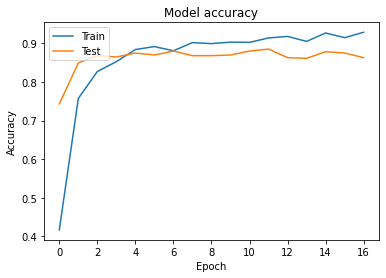

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

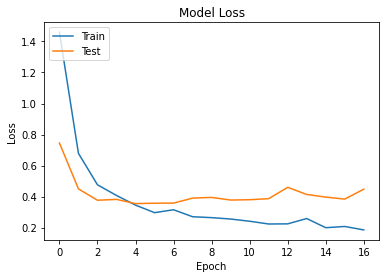

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# !pip install shap

# Prediction

In [ ]:
from keras.models import load_model
trained_model = load_model('news_BiLSTM_Skip_Atten_w2v256.hdf5',custom_objects=create_custom_objects())

In [ ]:
doc = '''  Mounting trade friction between the
  U.S. And Japan has raised fears among many of Asia's exporting
  nations that the row could inflict far-reaching economic
  damage, businessmen and officials said.
      They told Reuter correspondents in Asian capitals a U.S.
  Move against Japan might boost protectionist sentiment in the
  U.S. And lead to curbs on American imports of their products.
      But some exporters said that while the conflict would hurt
  them in the long-run, in the short-term Tokyo's loss might be
  their gain.
      The U.S. Has said it will impose 300 mln dlrs of tariffs on
  imports of Japanese electronics goods on April 17, in
  retaliation for Japan's alleged failure to stick to a pact not
  to sell semiconductors on world markets at below cost.
      Unofficial Japanese estimates put the impact of the tariffs
  at 10 billion dlrs and spokesmen for major electronics firms
  said they would virtually halt exports of products hit by the
  new taxes.
      "We wouldn't be able to do business," said a spokesman for
  leading Japanese electronics firm Matsushita Electric
  Industrial Co Ltd &lt;MC.T>.
      "If the tariffs remain in place for any length of time
  beyond a few months it will mean the complete erosion of
  exports (of goods subject to tariffs) to the U.S.," said Tom
  Murtha, a stock analyst at the Tokyo office of broker &lt;James
  Capel and Co>.
      In Taiwan, businessmen and officials are also worried.
      "We are aware of the seriousness of the U.S. Threat against
  Japan because it serves as a warning to us," said a senior
  Taiwanese trade official who asked not to be named.
      Taiwan had a trade trade surplus of 15.6 billion dlrs last
  year, 95 pct of it with the U.S.
      The surplus helped swell Taiwan's foreign exchange reserves
  to 53 billion dlrs, among the world's largest.
      "We must quickly open our markets, remove trade barriers and
  cut import tariffs to allow imports of U.S. Products, if we
  want to defuse problems from possible U.S. Retaliation," said
  Paul Sheen, chairman of textile exporters &lt;Taiwan Safe Group>.
      A senior official of South Korea's trade promotion
  association said the trade dispute between the U.S. And Japan
  might also lead to pressure on South Korea, whose chief exports
  are similar to those of Japan.
      Last year South Korea had a trade surplus of 7.1 billion
  dlrs with the U.S., Up from 4.9 billion dlrs in 1985.
      In Malaysia, trade officers and businessmen said tough
  curbs against Japan might allow hard-hit producers of
  semiconductors in third countries to expand their sales to the
  U.S.
      In Hong Kong, where newspapers have alleged Japan has been
  selling below-cost semiconductors, some electronics
  manufacturers share that view. But other businessmen said such
  a short-term commercial advantage would be outweighed by
  further U.S. Pressure to block imports.
      "That is a very short-term view," said Lawrence Mills,
  director-general of the Federation of Hong Kong Industry.
      "If the whole purpose is to prevent imports, one day it will
  be extended to other sources. Much more serious for Hong Kong
  is the disadvantage of action restraining trade," he said.
      The U.S. Last year was Hong Kong's biggest export market,
  accounting for over 30 pct of domestically produced exports.
      The Australian government is awaiting the outcome of trade
  talks between the U.S. And Japan with interest and concern,
  Industry Minister John Button said in Canberra last Friday.
      "This kind of deterioration in trade relations between two
  countries which are major trading partners of ours is a very
  serious matter," Button said.
      He said Australia's concerns centred on coal and beef,
  Australia's two largest exports to Japan and also significant
  U.S. Exports to that country.
      Meanwhile U.S.-Japanese diplomatic manoeuvres to solve the
  trade stand-off continue.
      Japan's ruling Liberal Democratic Party yesterday outlined
  a package of economic measures to boost the Japanese economy.
      The measures proposed include a large supplementary budget
  and record public works spending in the first half of the
  financial year.
      They also call for stepped-up spending as an emergency
  measure to stimulate the economy despite Prime Minister
  Yasuhiro Nakasone's avowed fiscal reform program.
      Deputy U.S. Trade Representative Michael Smith and Makoto
  Kuroda, Japan's deputy minister of International Trade and
  Industry (MITI), are due to meet in Washington this week in an
  effort to end the dispute. My name is Jack, I want to buy house, Please help me.
'''

In [ ]:
sentence_test = tokenizer.texts_to_sequences([doc])
sentence_test = pad_sequences(sentence_test, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(trained_model, X[:100])
explainer = shap.KernelExplainer(trained_model.predict, X[:100])
# explainer = shap.GradientExplainer(model, X[:100])
# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs


In [ ]:
shap_values = explainer.shap_values(sentence_test)

In [ ]:
words = tokenizer.word_index
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
sentence_words = np.stack(np.array(list(map(lambda x: num2word.get(x, "NONE"), sentence_test[0]))) )


In [ ]:
shap.initjs()
y_pred = trained_model.predict(sentence_test)
ind = np.argmax(y_pred)
# print('Actual Category: %s, Predict Category: %s' % (Y_test[0], y_pred[0]))
shap.force_plot(explainer.expected_value[ind], shap_values[ind][0],sentence_words)